In [1]:
from astroquery.vizier import Vizier
from astroquery.sdss import SDSS
import astropy.units as u
from astropy import coordinates as coords
from astropy.table import Table, hstack, vstack
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from synphot import SourceSpectrum
from synphot.models import Empirical1D
from synphot import units
import random
import os.path
from collections import Counter
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import snr_derived


In [2]:
# Search Vizier for Ritter-Kolb 'B/cb': 'Cataclysmic Binaries, LMXBs, and related objects (Ritter+, 2004)'
catalog_list = Vizier.find_catalogs('B/cb')
print({k:v.description for k,v in catalog_list.items()})


{'B/cb': 'Cataclysmic Binaries, LMXBs, and related objects (Ritter+, 2004)', 'J/ApJ/763/L33': 'Be-B concentrations in rare CB/CH chondrite (Gounelle+, 2013)'}


In [70]:
# Check index of 'B/cb/cbdata: Catalogue of Cataclysmic Binaries (1429 rows)'
Vizier.ROW_LIMIT = -1
catalogs = Vizier.get_catalogs(catalog_list.keys())
print(catalogs)


TableList with 11 tables:
	'0:B/cb/cbdata' with 11 column(s) and 1429 row(s) 
	'1:B/cb/lmxbdata' with 11 column(s) and 108 row(s) 
	'2:B/cb/pcbdata' with 11 column(s) and 619 row(s) 
	'3:B/cb/findrefs' with 3 column(s) and 4858 row(s) 
	'4:B/cb/cbrefs' with 3 column(s) and 2953 row(s) 
	'5:B/cb/lmxbrefs' with 3 column(s) and 310 row(s) 
	'6:B/cb/pcbrefs' with 3 column(s) and 1201 row(s) 
	'7:B/cb/whoswho1' with 3 column(s) and 12814 row(s) 
	'8:B/cb/whoswho2' with 3 column(s) and 7307 row(s) 
	'9:B/cb/whoswho5' with 2 column(s) and 1543 row(s) 
	'10:J/ApJ/763/L33/table1' with 13 column(s) and 74 row(s) 


In [4]:
# Finally get the CBdata
RKcat_cb = catalogs[0]
print("CBdata objects:", len(RKcat_cb))


CBdata objects: 1429


In [ ]:
RKcat_cb.write('tables/cbdata.ecsv')


In [2]:
RKcat_cb = Table.read('tables/cbdata.ecsv')


In [107]:
# Example
RKcat_cb[0:2]


Name,AltName,RAJ2000,DEJ2000,Type1,Type2,mag1,Orb.Per,SpType2,SpType1,Refs
,,"""h:m:s""","""d:m:s""",,,mag,d,,,
str12,str12,str10,str9,str2,str2,float32,float64,str7,str7,str4
V1017 Sgr,N Sgr 1919,18 32 04.5,-29 23 12,Nb,DN,13.7,5.714000,G5/3p,--,Refs
MR Vel,0925-4758,09 25 45.9,-47 58 18,SS,--,17.0,4.028782,--,--,Refs


In [4]:
# Dictionary with objects with available SDSS spectrum
RKcb_spec = {}
for i in range(len(RKcat_cb)):
    coord = RKcat_cb[i]['RAJ2000']+" "+RKcat_cb[i]['DEJ2000']
    pos = coords.SkyCoord(coord, unit=(u.hourangle, u.deg))
    # Query SDSS, default 2 arcsec radio
    xid = SDSS.query_region(pos, spectro=True, data_release=17)
    if xid!=None:
        RKcb_spec[RKcat_cb[i]['Name']] = xid
print("Objects with SDSS spectrum:", len(RKcb_spec))


C:\Users\AntonioOrtega\AppData\Local\Programs\Python\Python39\lib\site-packages\astropy\table\table.py:3486: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other
C:\Users\AntonioOrtega\AppData\Local\Programs\Python\Python39\lib\site-packages\astroquery\sdss\core.py:867: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


Objects with SDSS spectrum: 220


In [7]:
# Example
list(RKcb_spec)[0]


'J2044-0459'

In [5]:
RKcb_spec['J2044-0459']


ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d
float64,float64,int64,int32,int32,int32,int32,float64,int32,int32,int32,int64,int32
311.203848782275,-4.99134390921089,1237652936177811877,1737,301,6,25,-3.872241e-05,1916,53269,424,2157340824587757568,26
311.203848782275,-4.99134390921089,1237652936177811877,1737,301,6,25,-4.329716e-05,635,52145,387,715052854582208512,26


In [278]:
# 1st round for joint table (CV table + spectrum dictionary)
RKcat_cb_spec = Table()
for i in range(len(list(RKcb_spec))):
    t1 = RKcat_cb[RKcat_cb['Name']==list(RKcb_spec)[i]]
    t2 = RKcb_spec[list(RKcb_spec)[i]]
    t2p = Table()
    t1p = Table()
    for j in range(len(t2)):
        t2t = Table(t2[j], copy=True, dtype=('float64', 'float64', 'int64', 'int32', 'int32', 'int32', 'int32', 'float64', 'int32', 'int32', 'int32', 'int64', 'S7'))
        t2p = vstack([t2p, t2t])
        t1p = vstack([t1p, t1])
    o = hstack([t1p, t2p])
    RKcat_cb_spec = vstack([RKcat_cb_spec, o])


In [276]:
RKcat_cb_spec.write('tables/cbdata_w_spec.ecsv')


In [6]:
RKcat_cb_spec=Table.read('tables/cbdata_w_spec.ecsv')


In [3]:
# Download spectrum files:
error = []
for l in range(len(RKcat_cb_spec)):
    plate = RKcat_cb_spec[l]['plate']
    mjd = RKcat_cb_spec[l]['mjd']
    fiber = RKcat_cb_spec[l]['fiberID']
    filename = 'spec-'+str(plate).zfill(4)+'-'+str(mjd)+'-'+str(fiber).zfill(4)+'.fits'
    if not os.path.exists('SDSSspec/'+filename):
        try:
            spec = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiber, data_release=17)
            spec[0].writeto('SDSSspec/'+filename)
        except:
            csv_row = str(plate).zfill(4)+', '+str(mjd)+', '+str(fiber).zfill(4)
            error.append(csv_row)

with open('SDSSspec/error.txt', 'w') as f:
    for element in error:
        f.write(element + "\n")


C:\Users\AntonioOrtega\AppData\Local\Programs\Python\Python39\lib\site-packages\astroquery\sdss\core.py:867: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
MC1TRCT =-0.00000000000000E+00 / sp1 mech Temp_Red_Cam_Top                       [astropy.io.fits.card]


In [11]:
# 2nd round for joint table, with class and subclass (from .fits) and SNR
RKcat_cb_spec_class = Table()
obtyp = Table(names=('class', 'subclass', 'sppixmask', 'zwarning', 'good', 'snr'), dtype=('S10', 'S10', 'S100', 'S100', 'bool', 'f8'))
for i in range(len(RKcat_cb_spec)):
    bitset_m = set()
    bitset_z = set()
    p = RKcat_cb_spec[i]['plate']
    m = RKcat_cb_spec[i]['mjd']
    f = RKcat_cb_spec[i]['fiberID']
    filename = 'spec-'+str(p).zfill(4)+'-'+str(m)+'-'+str(f).zfill(4)+'.fits'
    spec1d = Spectrum1D.read('cbdata_w_spec/'+filename)
    snrval = snr_derived(spec1d, SpectralRegion(4000*u.AA, 9000*u.AA))
    hdul = fits.open('cbdata_w_spec/'+filename)
    andmk = hdul[1].data['and_mask']
    zwarn = hdul[2].data['ZWARNING']
    counter = 0
    for v in range(len(zwarn)):
        bits = [bit for bit in range(0, 32) if (zwarn[v] & 1 << bit) > 0]
        if bits!=[]:
            bitset_z.update(bits)
    for v in range(len(andmk)):
        bits = [bit for bit in range(0, 32) if (andmk[v] & 1 << bit) > 0]
        if bits!=[]:
            # if 23 in bits: bits.remove(23)
            if bits!=[]: counter=counter+1
            bitset_m.update(bits)
    #goodpct = Counter(andmk)[0]/len(andmk)
    badpct = counter/len(andmk)
    goodfl = True
    if badpct>0.1:
        goodfl = False
    #zztop = False
    #if zwarn==0:
    #    zztop=True
    obtyp.add_row((hdul[2].data['CLASS'][0], hdul[2].data['SUBCLASS'][0], str(bitset_m), str(bitset_z), goodfl, snrval))
RKcat_cb_spec_class = hstack([RKcat_cb_spec, obtyp])


MC1TRCT =-0.00000000000000E+00 / sp1 mech Temp_Red_Cam_Top                       [astropy.io.fits.card]


In [13]:
RKcat_cb_spec_class.write('tables/cbdata_w_spec_class.ecsv', overwrite=True)


In [44]:
RKcat_cb_spec_class=Table.read('tables/cbdata_w_spec_class.ecsv')


In [14]:
RKcat_cb_spec_class


Name,AltName,RAJ2000,DEJ2000,Type1,Type2,mag1,Orb.Per,SpType2,SpType1,Refs,ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d,class,subclass,sppixmask,zwarning,good,snr
,,"""h:m:s""","""d:m:s""",,,mag,d,,,,,,,,,,,,,,,,,,,,,,
str10,str11,str10,str9,str2,str2,float32,float64,str7,str6,str4,float64,float64,int64,int32,int32,int32,int32,float64,int32,int32,int32,int64,str7,bytes10,bytes14,bytes100,bytes100,bool,float64
J2044-0459,--,20 44 48.9,-04 59 29,DN,UG,16.7,1.680000,K4-5,--,Refs,311.203848782275,-4.99134390921089,1237652936177811877,1737,301,6,25,-3.872241e-05,1916,53269,424,2157340824587757568,26,STAR,CV,"{16, 23}",set(),True,38.6765724791674
J2044-0459,--,20 44 48.9,-04 59 29,DN,UG,16.7,1.680000,K4-5,--,Refs,311.203848782275,-4.99134390921089,1237652936177811877,1737,301,6,25,-4.329716e-05,635,52145,387,715052854582208512,0,STAR,CV,"{27, 23}",set(),True,32.95863805140221
V479 And,--,00 18 56.9,+34 54 44,NL,AM,17.5,0.594093,G8-K0/4,--,Refs,4.73724197215756,34.9122818603356,1237659888119578900,3356,301,3,30,-0.0002891821,1468,52999,163,1652865918658701312,26,STAR,CV,{23},{4},True,43.71896416570083
FH Lyn,--,08 13 21.9,+45 28 10,DN,UG,18.3,0.289000,K5-7/5,--,Refs,123.341349362666,45.4692502685502,1237651250945392740,1345,301,3,107,-0.0003028748,439,51877,582,494430069536614400,26,STAR,CV,"{16, 27, 23}",set(),True,18.607032618991305
FH Lyn,--,08 13 21.9,+45 28 10,DN,UG,18.3,0.289000,K5-7/5,--,Refs,123.341349362666,45.4692502685502,1237651250945392740,1345,301,3,107,0.0001062983,3686,55268,46,4150079789389338624,v5_13_2,STAR,CV,{23},set(),True,29.79928728439274
J1619+1351,--,16 19 09.1,+13 51 46,DN,UG,19.1,0.286500,K2-6/5,--,Refs,244.787925329688,13.8626610537507,1237668337399234623,5323,301,5,110,0.0003715811,2530,53881,327,2848616714499811328,26,STAR,CV,"{16, 23}",set(),True,20.887518488235695
U Leo,N Leo 1855,10 24 03.9,+14 00 26,N,--,17.3,0.267400,--,--,Refs,156.01610595075,14.006983990989,1237664106855006340,4338,301,5,88,-0.0009487064,5340,56011,358,6012404009679476736,v5_13_2,STAR,F3/F5V (30743),{23},set(),True,50.59864571401881
J1544+2553,--,15 44 53.6,+25 53 49,CV,--,16.6,0.251282,M1.5/5,--,Refs,236.223359844373,25.8969095422513,1237662697573056566,4010,301,4,152,0.0001735896,1849,53846,74,2081809333242324992,26,STAR,CV,{23},set(),True,37.368734319118595


In [16]:
# Plot, probably simpler & better with specutils.Spectrum1D when loading the .fits file, instead of synphot.SourceSpectrum
def plotspec(plate, mjd, fiber, direc, title, g, c, save=False):
    filename = 'spec-'+str(plate).zfill(4)+'-'+str(mjd)+'-'+str(fiber).zfill(4)+'.fits'
    hdul = fits.open(direc+filename)
    #hdul.info()
    flux = hdul[1].data['flux']*1e-17*units.FLAM
    loglam = hdul[1].data['loglam']
    wave = 10 ** loglam

    sp = SourceSpectrum(Empirical1D, points=wave, lookup_table=flux, keep_neg=False)
    spu = units.convert_flux(sp.waveset, sp(sp.waveset), units.FLAM)

    plt.figure(figsize=(16,4))
    #plt.plot(sp.waveset.value, sp(sp.waveset).value)
    plt.plot(sp.waveset.value, spu.value)
    plt.xlabel('Wavelength [Ångströms]')
    plt.ylabel('Flux [erg/cm²/s/Å]')
    plt.title(title+' ; '+hdul[2].data['CLASS'][0]+' '+hdul[2].data['SUBCLASS'][0])
    if save==True:
        if g==False:
            folderout='bad/'
        else:
            if c!='STAR CV':
                folderout='other/'
            else:
                folderout='spec/'
        plt.savefig(folderout+'spec-'+str(plate).zfill(4)+'-'+str(mjd)+'-'+str(fiber).zfill(4)+'.png', facecolor='white', edgecolor='none')
    else:
        plt.show()

def plotspec_ob(object, save=False):
    p=object['plate']
    m=object['mjd']
    f=object['fiberID']
    t=object['Name']
    g=object['good']
    c=str(object['class'])+' '+str(object['subclass'])
    print(t+' ; '+str(p)+'-'+str(m)+'-'+str(f))
    plotspec(p, m, f, 'cbdata_w_spec/', t+' ; '+str(p)+'-'+str(m)+'-'+str(f), g, c, save)


In [12]:
# Just out of curiosity
def plotspecmask(plate, mjd, fiber, direc, title, save=False):
    filename = 'spec-'+str(plate).zfill(4)+'-'+str(mjd)+'-'+str(fiber).zfill(4)+'.fits'
    hdul = fits.open(direc+filename)
    andmk = hdul[1].data['and_mask']
    loglam = hdul[1].data['loglam']
    wave = 10 ** loglam

    plt.figure(figsize=(16,4))
    plt.plot(wave, andmk)
    plt.xlabel('Wavelength [Ångströms]')
    plt.ylabel('Mask')
    plt.title(title+' ; '+hdul[2].data['CLASS'][0]+' '+hdul[2].data['SUBCLASS'][0])
    plt.show()

def plotspec_obmask(object, save=False):
    p=object['plate']
    m=object['mjd']
    f=object['fiberID']
    t=object['Name']
    print(t+' ; '+str(p)+'-'+str(m)+'-'+str(f))
    plotspecmask(p, m, f, 'cbdata_w_spec/', t+' ; '+str(p)+'-'+str(m)+'-'+str(f), save)


In [ ]:
# Plot (and save) spectrum loop
for l in range(len(RKcat_cb_spec_class)):
    plotspec_ob(RKcat_cb_spec_class[l], save=True)


J0043-0037 ; 1085-52531-175


  points: [3845.9182 5578.2764 7316.4434 8639.729  8651.67   8721.676  8753.867
 8767.988  8786.178  8792.247  8832.833  8887.919  8889.964  8892.009
 8900.204  8902.256  8904.304  8910.456  8926.887  8939.226  8943.344
 8951.586  8953.6455 8957.7705 8963.964  8968.089  8972.221  8988.766
 8992.907  8994.976  9042.739  9044.819  9084.48   9097.037  9101.229
 9109.616  9151.661  9157.988  9160.096  9185.439 ]
  lookup_table: [-3.25668648e-06 -1.94963338e-05 -8.72763549e-07 -3.81171093e-06
 -2.64513537e-06 -3.06165375e-06 -3.60491129e-07 -3.92126980e-06
 -1.63856818e-06 -2.47586588e-06 -4.13931448e-06 -9.23577247e-07
 -3.50127021e-06 -1.98364370e-06 -1.20365936e-06 -2.67000725e-06
 -5.33019978e-06 -2.27960268e-07 -8.19904070e-07 -1.39385261e-06
 -6.28006214e-06 -7.12697463e-07 -3.61821034e-06 -6.19155658e-06
 -1.40635169e-05 -4.35480933e-06 -9.55982386e-06 -7.83519543e-06
 -1.43106561e-05 -2.34553988e-07 -3.09284670e-07 -4.19990455e-07
 -1.46300820e-06 -1.65641419e-06 -6.01578919e-06 -4.

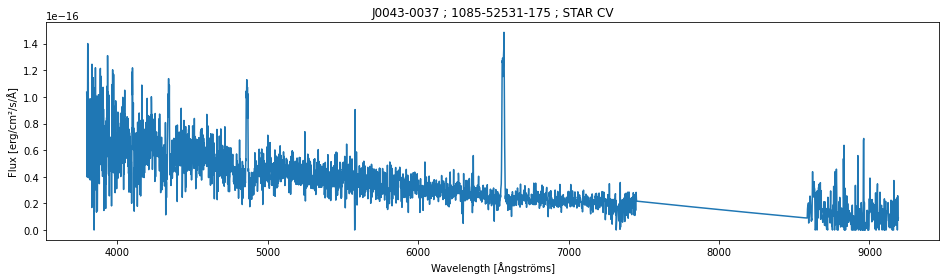

In [17]:
plotspec_ob(RKcat_cb_spec_class[269])


In [15]:
#plotspec_obmask(RKcat_cb_spec_class[269])
